## Imports

In [1]:
import numpy as np
from sklearn import datasets
import JOPLEn.singletask as jp
from JOPLEn.enums import *
from sklearn.ensemble import (
    ExtraTreesRegressor,
    RandomForestRegressor,
    GradientBoostingRegressor,
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor, DummyClassifier
from itertools import product
import warnings
import sklearn
from collections import defaultdict

# Hide future warnings because ax uses deprecated functions from pandas
warnings.simplefilter(action="ignore", category=FutureWarning)
# Hide unfixable warning from ax (warns about default behavior but there isn't
# a clear way to turn the warning off)
warnings.simplefilter(action="ignore", category=UserWarning)
from ax import optimize
import lightgbm as lgbm
from pathlib import Path
from copy import copy, deepcopy
import yaml
import time
from pprint import pprint
from ax.service.ax_client import AxClient, ObjectiveProperties
from tqdm import tqdm
import matplotlib.pyplot as plt
import logging
from ax.utils.common.logger import ROOT_STREAM_HANDLER
from JOPLEn.partitioner import VPartition
from JOPLEn.enums import CellModel

ROOT_STREAM_HANDLER.setLevel(logging.ERROR)

CACHE_DIR = Path("cache") / "experiments"
CACHE_DIR.mkdir(parents=True, exist_ok=True)

DS_PATH = Path("..") / "datasets" / "pmlb" / "processed"


In [2]:
# too many samples, causes JOPLEn to crash
EXCLUDE = [
    "1191_BNG_pbc",
    "215_2dplanes",
    "1201_BNG_breastTumor",
    "1196_BNG_pharynx",
    "1595_poker",
    "1203_BNG_pwLinear",
]


## Parameters

In [3]:
lgbm_params = [
    {
        "name": "num_leaves",
        "type": "range",
        "bounds": [2, 32],
        "value_type": "int",
    },
    {
        "name": "n_estimators",
        "type": "range",
        "bounds": [10, 1000],
        "value_type": "int",
        "log_scale": True,
    },
    {
        "name": "learning_rate",
        "type": "range",
        "bounds": [1e-5, 1e-1],
        "value_type": "float",
    },
    {
        "name": "reg_alpha",
        "type": "range",
        "bounds": [1e-5, 1e1],
        "value_type": "float",
        "log_scale": True,
    },
    {
        "name": "reg_lambda",
        "type": "range",
        "bounds": [1e-5, 1e1],
        "value_type": "float",
        "log_scale": True,
    },
    {
        "name": "random_state",
        "type": "fixed",
        "value": 0,
        "value_type": "int",
    },
    {
        "name": "verbose",
        "type": "fixed",
        "value": -1,
        "value_type": "int",
    },
]

sklgb_params = [
    {
        "name": "learning_rate",
        "type": "range",
        "bounds": [1e-5, 1e-1],
        "value_type": "float",
    },
    {
        "name": "n_estimators",
        "type": "range",
        "bounds": [10, 1000],
        "value_type": "int",
        "log_scale": True,
    },
    {
        "name": "criterion",
        "type": "choice",
        "values": ["friedman_mse", "squared_error"],
        "value_type": "str",
        "is_ordered": True,
    },
    {
        "name": "max_leaf_nodes",
        "type": "range",
        "bounds": [2, 32],
        "value_type": "int",
    },
    {
        "name": "ccp_alpha",
        "type": "range",
        "bounds": [1e-5, 1e1],
        "value_type": "float",
        "log_scale": True,
    },
    {
        "name": "max_depth",
        "type": "range",
        "bounds": [1, 5],
        "value_type": "int",
    },
    {
        "name": "random_state",
        "type": "fixed",
        "value": 0,
        "value_type": "int",
    },
]

sklrf_params = [
    {
        "name": "n_estimators",
        "type": "range",
        "bounds": [10, 1000],
        "value_type": "int",
        "log_scale": True,
    },
    {
        "name": "criterion",
        "type": "choice",
        "values": ["friedman_mse", "squared_error"],
        "value_type": "str",
        "is_ordered": True,
    },
    {
        "name": "max_leaf_nodes",
        "type": "range",
        "bounds": [2, 32],
        "value_type": "int",
    },
    {
        "name": "ccp_alpha",
        "type": "range",
        "bounds": [1e-5, 1e1],
        "value_type": "float",
        "log_scale": True,
    },
    {
        "name": "max_depth",
        "type": "range",
        "bounds": [1, 5],
        "value_type": "int",
    },
    {
        "name": "random_state",
        "type": "fixed",
        "value": 0,
        "value_type": "int",
    },
    {
        "name": "n_jobs",
        "type": "fixed",
        "value": -1,
        "value_type": "int",
    },
]

skletr_params = [
    {
        "name": "n_estimators",
        "type": "range",
        "bounds": [10, 1000],
        "value_type": "int",
        "log_scale": True,
    },
    {
        "name": "criterion",
        "type": "choice",
        "values": ["friedman_mse", "squared_error"],
        "value_type": "str",
        "is_ordered": True,
    },
    {
        "name": "max_leaf_nodes",
        "type": "range",
        "bounds": [2, 32],
        "value_type": "int",
    },
    {
        "name": "max_depth",
        "type": "range",
        "bounds": [1, 5],
        "value_type": "int",
    },
    {
        "name": "random_state",
        "type": "fixed",
        "value": 0,
        "value_type": "int",
    },
    {  # makes the feature selection totally random
        "name": "max_features",
        "type": "fixed",
        "value": 1,
        "value_type": "int",
    },
]

joplen_params = [
    {
        "name": "n_cells",
        "type": "range",
        "bounds": [2, 32],
        "value_type": "int",
    },
    {
        "name": "n_partitions",
        "type": "range",
        "bounds": [10, 1000],
        "value_type": "int",
        "log_scale": True,
    },
    {
        "name": "lam",
        "type": "range",
        "bounds": [0.0, 2.0],
        "value_type": "float",
    },
    {
        "name": "alpha",
        "type": "range",
        "bounds": [1e-5, 1e1],
        "value_type": "float",
        "log_scale": True,
    },
    {
        "name": "mu",
        "type": "fixed",
        "value": 1e-1,
        "value_type": "float",
    },
    {
        "name": "random_state",
        "type": "fixed",
        "value": 0,
        "value_type": "int",
    },
    {
        "name": "partitioner",
        "type": "fixed",
        "value": "VPartition",
        "value_type": "str",
    },
    {
        "name": "cell_model",
        "type": "fixed",
        "value": "CellModel.linear",
        "value_type": "str",
    },
    {
        "name": "max_iters",
        "type": "fixed",
        "value": 10000,
        "value_type": "int",
    },
    {
        "name": "norm_type",
        "type": "fixed",
        "value": "NormType.L21",
        "value_type": "str",
    },
    {
        "name": "verbose",
        "type": "fixed",
        "value": False,
        "value_type": "bool",
    },
]


## Training Functions

In [4]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)


def timer_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time

        return (result, start_time, end_time, elapsed_time)

    return wrapper


@timer_decorator
def train_lgbm(params, x_train, y_train, x_val, y_val, x_test=None, y_test=None):
    model = lgbm.LGBMRegressor(**params)
    model.fit(
        x_train,
        y_train.flatten(),
        # TODO: Need to re-enable validation set
        eval_set=[(x_val, y_val.flatten())],
        # verbose=-1,
        callbacks=[],
    )

    val_error = float(rmse(y_val.flatten(), model.predict(x_val)))

    if x_test is not None and y_test is not None:
        test_error = float(rmse(y_test.flatten(), model.predict(x_test)))
        return val_error, test_error, model
    else:
        return val_error, model


@timer_decorator
def train_sklearn(
    ModelClass, params, x_train, y_train, x_val, y_val, x_test=None, y_test=None
):
    model = ModelClass(**params)
    model.fit(x_train, y_train.flatten())

    val_error = float(rmse(y_val.flatten(), model.predict(x_val)))

    if x_test is not None and y_test is not None:
        test_error = float(rmse(y_test.flatten(), model.predict(x_test)))
        return val_error, test_error, model
    else:
        return val_error, model


def train_gbr(params, x_train, y_train, x_val, y_val, x_test=None, y_test=None):
    return train_sklearn(
        GradientBoostingRegressor,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )


def train_rfr(params, x_train, y_train, x_val, y_val, x_test=None, y_test=None):
    return train_sklearn(
        RandomForestRegressor,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )


def train_etr(params, x_train, y_train, x_val, y_val, x_test=None, y_test=None):
    return train_sklearn(
        ExtraTreesRegressor,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )


@timer_decorator
def train_joplen(
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
):
    joplen = jp.JOPLEn(
        partitioner=eval(params["partitioner"]),
        n_cells=params["n_cells"],
        n_partitions=params["n_partitions"],
        random_state=params["random_state"],
        cell_model=eval(params["cell_model"]),
    )
    joplen.fit(
        x_train,
        y_train,
        val_x=x_val,
        val_y=y_val,
        max_iters=params["max_iters"],
        norm_type=eval(params["norm_type"]),
        verbose=params["verbose"],
        mu=params["mu"],
        lam=params["lam"],
        alpha=params["alpha"],
    )

    val_error = float(rmse(y_val, joplen.predict(x_val)))

    if x_test is not None and y_test is not None:
        test_error = float(rmse(y_test, joplen.predict(x_test)))
        return val_error, test_error, joplen
    else:
        return val_error, joplen


In [5]:
def dummy_regressor(x_train, x_val, x_test, y_train, y_val, y_test, indent=False):
    dummy = DummyRegressor(strategy="mean")
    dummy.fit(x_train, y_train)
    y_pred = dummy.predict(x_test)

    res = {
        "model_name": dummy.__class__.__name__,
        "rmse": float(rmse(y_test, y_pred)),
    }

    return res


## Run Experiments

In [6]:
def optimize_model(
    model_class, ds_path, n_trials, minimize, loss_type, overwrite=False
):
    ds_name = ds_path.name

    match model_class:
        case lgbm.LGBMRegressor:
            params = lgbm_params
            train_fn = train_lgbm
        case sklearn.ensemble.GradientBoostingRegressor:
            params = sklgb_params
            train_fn = train_gbr
        case sklearn.ensemble.RandomForestRegressor:
            params = sklrf_params
            train_fn = train_rfr
        case sklearn.ensemble.ExtraTreesRegressor:
            params = skletr_params
            train_fn = train_etr
        case jp.JOPLEn:
            params = joplen_params
            train_fn = train_joplen
        case _:
            raise ValueError("Model not yet supported.")

    dir_path = Path("ax_runs") / model_class.__name__ / ds_name
    exp_path = dir_path / "experiment.json"
    metadata_path = dir_path / "metadata.yaml"

    if metadata_path.exists() and not overwrite:
        with open(metadata_path, "r") as f:
            metadata = yaml.load(f, Loader=yaml.FullLoader)
        return metadata

    x_train = np.loadtxt(ds_path / "x_train.csv", delimiter=",")
    x_val = np.loadtxt(ds_path / "x_val.csv", delimiter=",")
    x_test = np.loadtxt(ds_path / "x_test.csv", delimiter=",")
    y_train = np.loadtxt(ds_path / "y_train.csv", delimiter=",")
    y_val = np.loadtxt(ds_path / "y_val.csv", delimiter=",")
    y_test = np.loadtxt(ds_path / "y_test.csv", delimiter=",")

    dummy_info = dummy_regressor(
        x_train, x_val, x_test, y_train, y_val, y_test, indent=True
    )

    if not exp_path.exists() or overwrite:
        ax_client = AxClient(
            random_seed=0,
            verbose_logging=False,
        )

        ax_client.create_experiment(
            name=f"{model_class.__name__}_{ds_name}",
            parameters=params,
            objectives={loss_type: ObjectiveProperties(minimize=minimize)},
            overwrite_existing_experiment=True,
        )

        for _ in range(n_trials):
            round_params, trial_index = ax_client.get_next_trial()
            try:
                val_error, _ = train_fn(
                    round_params,
                    x_train=x_train,
                    y_train=y_train,
                    x_val=x_val,
                    y_val=y_val,
                )[0]
                ax_client.complete_trial(
                    trial_index=trial_index, raw_data=float(val_error)
                )
            except ValueError as e:
                print(e)
                ax_client.abandon_trial(
                    trial_index=trial_index,
                    reason=str(e),
                )
    else:
        ax_client = AxClient.load_from_json_file(filepath=exp_path)

    best_parameters, values = ax_client.get_best_parameters()

    (val_error, test_error, _), _, _, train_time = train_fn(
        best_parameters,
        x_train=x_train,
        y_train=y_train,
        x_val=x_val,
        y_val=y_val,
        x_test=x_test,
        y_test=y_test,
    )

    exp_path.parent.mkdir(parents=True, exist_ok=True)

    ax_client.save_to_json_file(
        filepath=exp_path,
    )

    metadata = {
        "model_name": str(model_class.__name__),
        "val_score": float(val_error),
        "test_score": float(test_error),
        "train_time": float(train_time),
        "params": best_parameters,
        "dummy_loss": float(dummy_info["rmse"]),
    }

    with open(metadata_path, "w") as f:
        yaml.dump(metadata, f)

    return metadata


In [10]:
reg_datasets = list((DS_PATH / "reg").iterdir())

reg_res = defaultdict(dict)

models = [
    lgbm.LGBMRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
    ExtraTreesRegressor,
    jp.JOPLEn,
]

itr = tqdm(reg_datasets)

for ds_path in itr:
    if ds_path.name in EXCLUDE:
        continue

    for model in models:
        model_str = f"{model.__name__} on {ds_path.name}"
        itr.set_description(f"Running {model_str : <50}")
        res = optimize_model(
            model,
            ds_path,
            10,
            True,
            "rmse",
        )

        reg_res[model.__name__][ds_path.name] = res

reg_res = dict(reg_res)


Running JOPLEn on titanic                                 : 100%|██████████| 122/122 [00:00<00:00, 143.52it/s]          


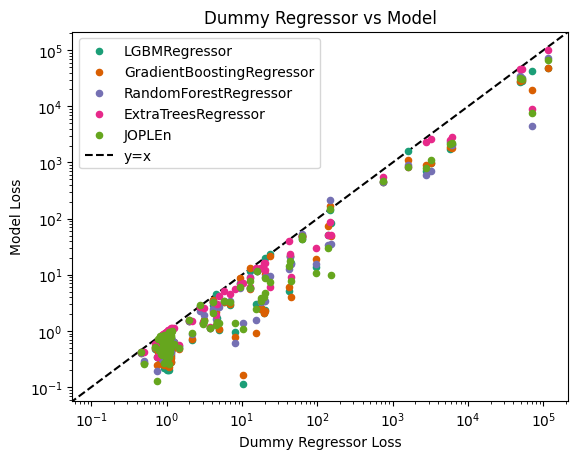

In [12]:
cmap = plt.get_cmap("Dark2")

for i, (k, v) in enumerate(reg_res.items()):
    dummy_pred = [vv["dummy_loss"] for vv in v.values()]
    lgbm_loss = [vv["test_score"] for vv in v.values()]

    plt.scatter(
        dummy_pred,
        lgbm_loss,
        label=k,
        s=20,
        zorder=1,
        color=cmap(i),
        # alpha=0.5,
    )

plt.yscale("log")
plt.xscale("log")

y_lim = plt.ylim()
x_lim = plt.xlim()

lim = (min(y_lim[0], x_lim[0]), max(y_lim[1], x_lim[1]))

plt.plot([1e-3, 1e6], [1e-3, 1e6], color="black", linestyle="--", label="y=x", zorder=0)
plt.ylim(lim)
plt.xlim(lim)

plt.legend()

plt.xlabel("Dummy Regressor Loss")
plt.ylabel("Model Loss")
plt.title("Dummy Regressor vs Model")

plt.show()
